# Application sur le CAC-40

In [1]:
# Importations de bibliothèques
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import linalg, optimize
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.covariance import GraphicalLassoCV, ledoit_wolf
from sklearn import covariance, cluster
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns
import yfinance as yf
import statsmodels.api as sm
from statsmodels import regression
import cvxopt as opt
from cvxopt import blas, solvers
from datetime import timedelta


In [2]:
stocks = "CAC-40"
web = pd.read_html("https://en.wikipedia.org/wiki/{}".format(stocks))[4]

In [3]:
web.head()

,Company,Sector,GICS Sub-Industry,Ticker
0,Air Liquide,Basic Materials,Industrial Gases,AI.PA
1,Airbus,Industrials,Aerospace & Defense,AIR.PA
2,Alstom,Industrials,Rail Transport,ALO.PA
3,ArcelorMittal,Basic Materials,Steel,MT.AS
4,Axa,Financial Services,Life & Health Insurance,CS.PA


In [4]:
tickers = list(web.Ticker)

#Affichage des 5 premiers
tickers[:5]

['AI.PA', 'AIR.PA', 'ALO.PA', 'MT.AS', 'CS.PA']

In [5]:
#Définition du début et fin de la collecte de données
start = '2015-01-01'
end = '2016-01-01'

#Collecte
data = yf.download(
    tickers,
    start,
    end
)
data.head()

[*********************100%%**********************]  40 of 40 completed

1 Failed download:
['URW.PA']: YFChartError("%ticker%: Data doesn't exist for startDate = 1420066800, endDate = 1451602800")


Price      Adj Close                                                         \
Ticker        ACA.PA      AI.PA     AIR.PA     ALO.PA      BN.PA     BNP.PA   
Date                                                                          
2015-01-02  5.949172  61.053139  36.543690  20.986086  39.666203  30.209675   
2015-01-05  5.676275  59.162537  36.653694  20.458992  38.649876  28.742893   
2015-01-06  5.567115  58.668812  37.502934  20.470705  38.532043  27.991165   
2015-01-07  5.487974  58.933746  38.479782  20.712778  38.981285  27.523624   
2015-01-08  5.621696  61.414398  39.791042  21.087599  40.108082  28.415922   

Price                                                   ...   Volume           \
Ticker          CA.PA     CAP.PA      CS.PA      DG.PA  ...   SAN.PA   SGO.PA   
Date                                                    ...                     
2015-01-02  18.577633  51.343330  11.170162  33.836468  ...  2009353  1014438   
2015-01-05  17.677460  50.660130  10.754934  32.685616  ...  4375082  2845756   
2015-01-06  17.536690  48.704437  10.637972  32.328072  ...  3341157  2684524   
2015-01-07  17.518167  48.909397  10.752012  33.519882  ...  4727635  2129441   
2015-01-08  18.314617  50.301445  11.196479  34.693081  ...  4686432  2304921   

Price                                                                    \
Ticker     STLAP.PA STMPA.PA    SU.PA  TEP.PA    TTE.PA URW.PA   VIE.PA   
Date                                                                      
2015-01-02        0  1063144  1004130   67748   4456793    NaN  1765620   
2015-01-05        0  1848068  2677991  134587  10754689    NaN  2468632   
2015-01-06        0  1588483  2419095   88564   9773351    NaN  3164952   
2015-01-07        0  1809120  1451756  109749   8174121    NaN  1822417   
2015-01-08        0  2508589  3073304   97733   9051105    NaN  3130473   

Price               
Ticker      WLN.PA  
Date                
2015-01-02   28668  
2015-01-05   53277  
2015-01-06   54780  
2015-01-07   20412  
2015-01-08  257124  

[5 rows x 240 columns]

In [6]:
failed_tickers = data.columns.get_level_values(1)[data.isnull().any() | (data == 0).any()].unique().tolist()
tickers = [ticker for ticker in tickers if ticker not in failed_tickers]

In [7]:
data.drop(columns=failed_tickers, level=1, inplace=True)
data.head()

Price      Adj Close                                                         \
Ticker        ACA.PA      AI.PA     AIR.PA     ALO.PA      BN.PA     BNP.PA   
Date                                                                          
2015-01-02  5.949172  61.053139  36.543690  20.986086  39.666203  30.209675   
2015-01-05  5.676275  59.162537  36.653694  20.458992  38.649876  28.742893   
2015-01-06  5.567115  58.668812  37.502934  20.470705  38.532043  27.991165   
2015-01-07  5.487974  58.933746  38.479782  20.712778  38.981285  27.523624   
2015-01-08  5.621696  61.414398  39.791042  21.087599  40.108082  28.415922   

Price                                                   ...   Volume           \
Ticker          CA.PA     CAP.PA      CS.PA      DG.PA  ...   RNO.PA   SAF.PA   
Date                                                    ...                     
2015-01-02  18.577633  51.343330  11.170162  33.836468  ...   556271   371455   
2015-01-05  17.677460  50.660130  10.754934  32.685616  ...  1141204   743160   
2015-01-06  17.536690  48.704437  10.637972  32.328072  ...   937753   769752   
2015-01-07  17.518167  48.909397  10.752012  33.519882  ...   872019   739959   
2015-01-08  18.314617  50.301445  11.196479  34.693081  ...  1247456  1361972   

Price                                                                      \
Ticker       SAN.PA   SGO.PA STMPA.PA    SU.PA  TEP.PA    TTE.PA   VIE.PA   
Date                                                                        
2015-01-02  2009353  1014438  1063144  1004130   67748   4456793  1765620   
2015-01-05  4375082  2845756  1848068  2677991  134587  10754689  2468632   
2015-01-06  3341157  2684524  1588483  2419095   88564   9773351  3164952   
2015-01-07  4727635  2129441  1809120  1451756  109749   8174121  1822417   
2015-01-08  4686432  2304921  2508589  3073304   97733   9051105  3130473   

Price               
Ticker      WLN.PA  
Date                
2015-01-02   28668  
2015-01-05   53277  
2015-01-06   54780  
2015-01-07   20412  
2015-01-08  257124  

[5 rows x 222 columns]

In [8]:
data.columns

MultiIndex([('Adj Close',   'ACA.PA'),
            ('Adj Close',    'AI.PA'),
            ('Adj Close',   'AIR.PA'),
            ('Adj Close',   'ALO.PA'),
            ('Adj Close',    'BN.PA'),
            ('Adj Close',   'BNP.PA'),
            ('Adj Close',    'CA.PA'),
            ('Adj Close',   'CAP.PA'),
            ('Adj Close',    'CS.PA'),
            ('Adj Close',    'DG.PA'),
            ...
            (   'Volume',   'RNO.PA'),
            (   'Volume',   'SAF.PA'),
            (   'Volume',   'SAN.PA'),
            (   'Volume',   'SGO.PA'),
            (   'Volume', 'STMPA.PA'),
            (   'Volume',    'SU.PA'),
            (   'Volume',   'TEP.PA'),
            (   'Volume',   'TTE.PA'),
            (   'Volume',   'VIE.PA'),
            (   'Volume',   'WLN.PA')],
           names=['Price', 'Ticker'], length=222)

In [9]:
s= set()
for column,_ in list(data.columns):
    s.add(column)
s

{'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'}

In [10]:
closing_prices = data["Close"]
opening_prices = data["Open"]

variation = closing_prices-opening_prices
variation.head()

Ticker,ACA.PA,AI.PA,AIR.PA,ALO.PA,BN.PA,BNP.PA,CA.PA,CAP.PA,CS.PA,DG.PA,...,RNO.PA,SAF.PA,SAN.PA,SGO.PA,STMPA.PA,SU.PA,TEP.PA,TTE.PA,VIE.PA,WLN.PA
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,0.062593,-1.170860,-0.014999,-0.023182,-0.970001,-0.255001,-0.219999,0.590000,-0.275000,-0.510002,...,-0.829998,-0.590000,-0.258583,-0.419998,-0.015,-0.709999,0.890003,-0.375000,-0.159088,0.100000
2015-01-05,-0.423703,-2.005112,0.525002,-0.468264,-0.920002,-1.945000,-1.129999,-0.360001,-0.610001,-1.084999,...,-1.809998,0.250000,-1.362556,-1.244999,-0.067,-2.009998,-0.329998,-2.240002,-0.279610,-0.309999
2015-01-06,-0.197408,-0.439072,0.795002,0.064909,-1.180000,-1.250000,-0.365000,-2.380001,-0.230000,-0.820000,...,-0.510002,0.299999,-0.487335,-0.734997,-0.092,0.059998,-0.930000,-0.245003,-0.231400,0.174999
2015-01-07,-0.202223,-0.234169,0.724998,0.254995,0.279999,-0.880001,-0.205000,-0.139999,0.059999,1.279999,...,-0.480000,0.619999,-0.805595,-0.299999,0.056,-0.030003,-0.049999,0.725002,0.024103,-0.195001
2015-01-08,0.048149,1.968521,1.014999,0.180815,0.969997,0.535000,0.804998,0.580002,0.450001,0.889999,...,1.469997,0.830002,1.839951,0.775002,0.127,0.650002,0.769997,0.905003,0.106059,-0.100000


In [11]:
alphas = np.logspace(-1.5, 1, num=10)
model = covariance.GraphicalLassoCV(alphas=alphas)

X = variation.copy()
X /= X.std(axis=0)
model.fit(X)

c:\Python312\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


GraphicalLassoCV(alphas=array([ 0.03162278,  0.05994843,  0.11364637,  0.21544347,  0.40842387,
        0.77426368,  1.46779927,  2.7825594 ,  5.27499706, 10.        ]))

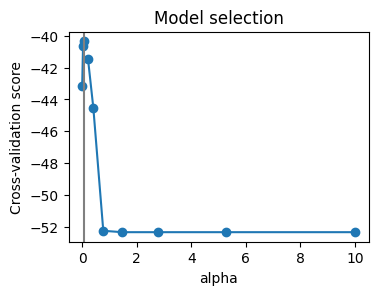

In [12]:
# plot the model selection metric
plt.figure(figsize=(4, 3))
plt.axes([0.2, 0.15, 0.75, 0.7])
plt.plot(model.cv_results_["alphas"], model.cv_results_["mean_test_score"], "o-")
plt.axvline(model.alpha_, color=".5")
plt.title("Model selection")
plt.ylabel("Cross-validation score")
plt.xlabel("alpha")

plt.show()

In [13]:
model.alpha_

0.05994842503189409

In [14]:
_, labels = cluster.affinity_propagation(model.covariance_, random_state=0)
n_labels = labels.max()
n_labels

7

In [15]:
labels

array([3, 4, 2, 0, 2, 3, 5, 2, 3, 5, 2, 1, 2, 5, 5, 3, 2, 4, 5, 4, 5, 3,
       2, 2, 5, 2, 4, 5, 2, 2, 5, 6, 5, 2, 5, 2, 7], dtype=int64)

In [16]:
clusters = {}

for i in range(len(labels)):
    cluster = labels[i]+1
    if cluster not in clusters:
        clusters[cluster]=[]
    clusters[cluster].append(tickers[i])

for cluster in clusters:
    print("Cluster "+str(cluster)+" : "+",".join(clusters[cluster]))

Cluster 4 : AI.PA,BNP.PA,CA.PA,RMS.PA,ORA.PA
Cluster 5 : AIR.PA,OR.PA,MC.PA,SGO.PA
Cluster 3 : ALO.PA,CS.PA,CAP.PA,BN.PA,EDEN.PA,KER.PA,RI.PA,PUB.PA,SAF.PA,SU.PA,GLE.PA,TTE.PA,DG.PA
Cluster 1 : MT.AS
Cluster 6 : EN.PA,ACA.PA,ENGI.PA,EL.PA,LR.PA,ML.PA,RNO.PA,SAN.PA,STMPA.PA,HO.PA,VIE.PA
Cluster 2 : DSY.PA
Cluster 7 : TEP.PA
Cluster 8 : WLN.PA


In [17]:
# Finding a low-dimension embedding for visualization: find the best position of
# the nodes (the stocks) on a 2D plane

from sklearn import manifold

node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver="dense", n_neighbors=6
)

embedding = node_position_model.fit_transform(X.T).T

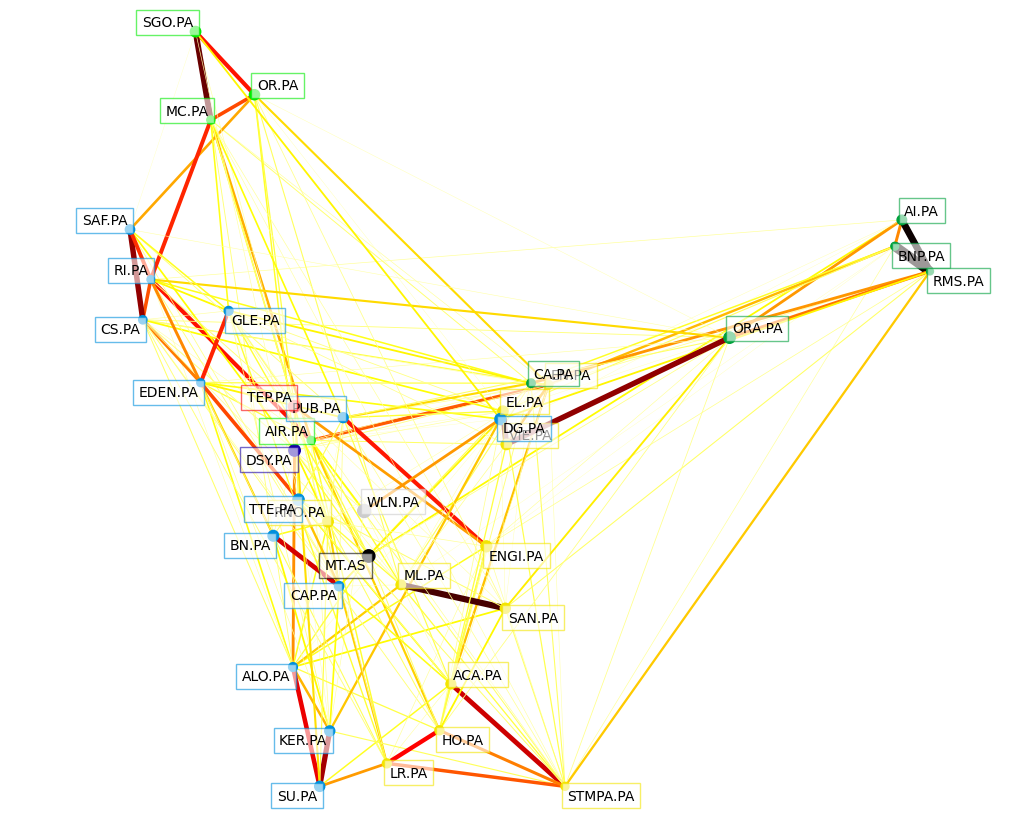

In [18]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

plt.figure(1, facecolor="w", figsize=(10, 8))
plt.clf()
ax = plt.axes([0.0, 0.0, 1.0, 1.0])
plt.axis("off")


partial_correlations = model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = np.abs(np.triu(partial_correlations, k=1)) > 0.02


plt.scatter(
    embedding[0], embedding[1], s=100 * d**2, c=labels, cmap=plt.cm.nipy_spectral
)

start_idx, end_idx = np.where(non_zero)
segments = [
    [embedding[:, start], embedding[:, stop]] for start, stop in zip(start_idx, end_idx)
]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(
    segments, zorder=0, cmap=plt.cm.hot_r, norm=plt.Normalize(0, 0.7 * values.max())
)
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

for index, (name, label, (x, y)) in enumerate(zip(tickers, labels, embedding.T)):
    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = "left"
        x = x + 0.002
    else:
        horizontalalignment = "right"
        x = x - 0.002
    if this_dy > 0:
        verticalalignment = "bottom"
        y = y + 0.002
    else:
        verticalalignment = "top"
        y = y - 0.002
    plt.text(
        x,
        y,
        name,
        size=10,
        horizontalalignment=horizontalalignment,
        verticalalignment=verticalalignment,
        bbox=dict(
            facecolor="w",
            edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
            alpha=0.6,
        ),
    )

plt.xlim(
    embedding[0].min() - 0.15 * np.ptp(embedding[0]),
    embedding[0].max() + 0.10 * np.ptp(embedding[0]),
)
plt.ylim(
    embedding[1].min() - 0.03 * np.ptp(embedding[1]),
    embedding[1].max() + 0.03 * np.ptp(embedding[1]),
)

plt.show()